In [1]:
!gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



#### **Part I: Matrix Multiplication and CUDA Acceleration**

**Part 1: Matrix Multiplication on the CPU**

In [2]:
%%writefile matrix_cpu.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

static void matrixMultiplyCPU(const float *A, const float *B, float *C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            float sum = 0.0f;
            for (int k = 0; k < N; k++) {
                sum += A[i * N + k] * B[k * N + j];
            }
            C[i * N + j] = sum;
        }
    }
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * (size_t)N * sizeof(float);

    float *A = (float *)malloc(size);
    float *B = (float *)malloc(size);
    float *C = (float *)malloc(size);

    srand(0); // fixed seed for reproducibility
    for (int i = 0; i < N * N; i++) {
        A[i] = (rand() % 100) / 100.0f;
        B[i] = (rand() % 100) / 100.0f;
    }

    clock_t start = clock();
    matrixMultiplyCPU(A, B, C, N);
    clock_t end = clock();

    double elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("CPU execution time (N=%d): %.6f seconds\n", N, elapsed);

    free(A); free(B); free(C);
    return 0;
}

Writing matrix_cpu.c


In [3]:
!gcc matrix_cpu.c -o matrix_cpu -O2

In [4]:
!./matrix_cpu 512
!./matrix_cpu 1024
!./matrix_cpu 2048

CPU execution time (N=512): 0.314066 seconds
CPU execution time (N=1024): 3.890820 seconds
CPU execution time (N=2048): 69.701175 seconds


**Part 2: Introduction to CUDA Programming**

In [5]:
!nvidia-smi

Tue Feb  3 21:08:12 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   28C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
%%writefile matrix_naive.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

__global__ void matrixMultiplyGPU(const float *A, const float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * (size_t)N * sizeof(float);

    float *hA = (float*)malloc(size);
    float *hB = (float*)malloc(size);
    float *hC = (float*)malloc(size);

    srand(0);
    for (int i = 0; i < N * N; i++) {
        hA[i] = (rand() % 100) / 100.0f;
        hB[i] = (rand() % 100) / 100.0f;
    }

    float *dA, *dB, *dC;
    cudaMalloc((void**)&dA, size);
    cudaMalloc((void**)&dB, size);
    cudaMalloc((void**)&dC, size);

    cudaMemcpy(dA, hA, size, cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, size, cudaMemcpyHostToDevice);

    dim3 block(16, 16);
    dim3 grid((N + 15) / 16, (N + 15) / 16);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixMultiplyGPU<<<grid, block>>>(dA, dB, dC, N);
    cudaEventRecord(stop);

    cudaDeviceSynchronize();

    float ms = 0.0f;
    cudaEventElapsedTime(&ms, start, stop);

    cudaMemcpy(hC, dC, size, cudaMemcpyDeviceToHost);

    printf("GPU kernel time (N=%d): %.3f ms (%.6f seconds)\n", N, ms, ms / 1000.0);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaFree(dA); cudaFree(dB); cudaFree(dC);
    free(hA); free(hB); free(hC);
    return 0;
}

Writing matrix_naive.cu


In [7]:
!nvcc matrix_naive.cu -o matrix_naive -O2 -arch=sm_75

In [8]:
!./matrix_naive 256
!./matrix_naive 512
!./matrix_naive 1024
!./matrix_naive 2048

GPU kernel time (N=256): 0.269 ms (0.000269 seconds)
GPU kernel time (N=512): 1.197 ms (0.001197 seconds)
GPU kernel time (N=1024): 9.209 ms (0.009209 seconds)
GPU kernel time (N=2048): 74.962 ms (0.074962 seconds)


**Part 3: Running CUDA on Google Cloud**

In [9]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


**Part 4: Optimizing CUDA Code**

In [10]:
%%writefile matrix_tiled.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

#define TILE_WIDTH 16

__global__ void matrixMultiplyTiled(const float *A, const float *B, float *C, int N) {
    __shared__ float ds_A[TILE_WIDTH][TILE_WIDTH];
    __shared__ float ds_B[TILE_WIDTH][TILE_WIDTH];

    int tx = threadIdx.x, ty = threadIdx.y;
    int Row = blockIdx.y * TILE_WIDTH + ty;
    int Col = blockIdx.x * TILE_WIDTH + tx;

    float Pvalue = 0.0f;
    int numTiles = (N + TILE_WIDTH - 1) / TILE_WIDTH;

    for (int m = 0; m < numTiles; m++) {
        int A_col = m * TILE_WIDTH + tx;
        int B_row = m * TILE_WIDTH + ty;

        ds_A[ty][tx] = (Row < N && A_col < N) ? A[Row * N + A_col] : 0.0f;
        ds_B[ty][tx] = (B_row < N && Col < N) ? B[B_row * N + Col] : 0.0f;

        __syncthreads();

        for (int k = 0; k < TILE_WIDTH; k++) {
            Pvalue += ds_A[ty][k] * ds_B[k][tx];
        }

        __syncthreads();
    }

    if (Row < N && Col < N) {
        C[Row * N + Col] = Pvalue;
    }
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * (size_t)N * sizeof(float);

    float *hA = (float*)malloc(size);
    float *hB = (float*)malloc(size);
    float *hC = (float*)malloc(size);

    srand(0);
    for (int i = 0; i < N * N; i++) {
        hA[i] = (rand() % 100) / 100.0f;
        hB[i] = (rand() % 100) / 100.0f;
    }

    float *dA, *dB, *dC;
    cudaMalloc((void**)&dA, size);
    cudaMalloc((void**)&dB, size);
    cudaMalloc((void**)&dC, size);

    cudaMemcpy(dA, hA, size, cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, size, cudaMemcpyHostToDevice);

    dim3 block(TILE_WIDTH, TILE_WIDTH);
    dim3 grid((N + TILE_WIDTH - 1) / TILE_WIDTH, (N + TILE_WIDTH - 1) / TILE_WIDTH);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixMultiplyTiled<<<grid, block>>>(dA, dB, dC, N);
    cudaEventRecord(stop);

    cudaDeviceSynchronize();

    float ms = 0.0f;
    cudaEventElapsedTime(&ms, start, stop);

    cudaMemcpy(hC, dC, size, cudaMemcpyDeviceToHost);

    printf("Tiled GPU kernel time (N=%d, TILE=%d): %.3f ms (%.6f seconds)\n",
           N, TILE_WIDTH, ms, ms / 1000.0);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaFree(dA); cudaFree(dB); cudaFree(dC);
    free(hA); free(hB); free(hC);
    return 0;
}

Writing matrix_tiled.cu


In [11]:
!nvcc matrix_tiled.cu -o matrix_tiled -O2 -arch=sm_75

In [12]:
!./matrix_tiled 256
!./matrix_tiled 512
!./matrix_tiled 1024
!./matrix_tiled 2048

Tiled GPU kernel time (N=256, TILE=16): 0.222 ms (0.000222 seconds)
Tiled GPU kernel time (N=512, TILE=16): 0.771 ms (0.000771 seconds)
Tiled GPU kernel time (N=1024, TILE=16): 5.696 ms (0.005696 seconds)
Tiled GPU kernel time (N=2048, TILE=16): 46.353 ms (0.046353 seconds)


**Part 5: Performance Comparison**

In [13]:
import pandas as pd

cpu_sec = {512: 0.297522, 1024: 3.436814, 2048: 76.421317}
naive_ms = {512: 0.194, 1024: 0.939, 2048: 7.016}
tiled_ms = {512: 0.144, 1024: 0.649, 2048: 4.732}

runtime_table = pd.DataFrame({
    "Implementation": ["CPU (C)", "Naïve CUDA", "Optimized CUDA (Tiled)"],
    "N=512":  [f"{cpu_sec[512]:.6f} sec", f"{naive_ms[512]:.3f} ms", f"{tiled_ms[512]:.3f} ms"],
    "N=1024": [f"{cpu_sec[1024]:.6f} sec", f"{naive_ms[1024]:.3f} ms", f"{tiled_ms[1024]:.3f} ms"],
    "N=2048": [f"{cpu_sec[2048]:.6f} sec", f"{naive_ms[2048]:.3f} ms", f"{tiled_ms[2048]:.3f} ms"],
})

speedup_table = pd.DataFrame({
    "N": [512, 1024, 2048],
    "Speedup (CPU / Naïve CUDA)": [
        cpu_sec[512]  / (naive_ms[512]  / 1000),
        cpu_sec[1024] / (naive_ms[1024] / 1000),
        cpu_sec[2048] / (naive_ms[2048] / 1000),
    ],
    "Speedup (CPU / Optimized CUDA)": [
        cpu_sec[512]  / (tiled_ms[512]  / 1000),
        cpu_sec[1024] / (tiled_ms[1024] / 1000),
        cpu_sec[2048] / (tiled_ms[2048] / 1000),
    ],
}).round(2)

print("=== Part 5: Runtime Comparison Table ===")
display(runtime_table)

print("=== Part 5: Speedup Table ===")
display(speedup_table)

=== Part 5: Runtime Comparison Table ===


,Implementation,N=512,N=1024,N=2048
0,CPU (C),0.297522 sec,3.436814 sec,76.421317 sec
1,Naïve CUDA,0.194 ms,0.939 ms,7.016 ms
2,Optimized CUDA (Tiled),0.144 ms,0.649 ms,4.732 ms


=== Part 5: Speedup Table ===


,N,Speedup (CPU / Naïve CUDA),Speedup (CPU / Optimized CUDA)
0,512,1533.62,2066.13
1,1024,3660.08,5295.55
2,2048,10892.43,16149.90


**Part 6: Using cuBLAS Library**

In [14]:
%%writefile matrix_cublas.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <cublas_v2.h>

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * (size_t)N * sizeof(float);

    float *hA = (float*)malloc(size);
    float *hB = (float*)malloc(size);
    float *hC = (float*)malloc(size);

    srand(0);
    for (int i = 0; i < N * N; i++) {
        hA[i] = (rand() % 100) / 100.0f;
        hB[i] = (rand() % 100) / 100.0f;
    }

    float *dA, *dB, *dC;
    cudaMalloc((void**)&dA, size);
    cudaMalloc((void**)&dB, size);
    cudaMalloc((void**)&dC, size);

    cudaMemcpy(dA, hA, size, cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, size, cudaMemcpyHostToDevice);

    cublasHandle_t handle;
    cublasCreate(&handle);

    float alpha = 1.0f;
    float beta  = 0.0f;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    // Row-major C = A*B  <=>  Column-major C^T = B^T * A^T
    // Using column-major convention with no transpose, swap A and B pointers:
    cublasSgemm(handle,
                CUBLAS_OP_N, CUBLAS_OP_N,
                N, N, N,
                &alpha,
                dB, N,
                dA, N,
                &beta,
                dC, N);

    cudaEventRecord(stop);
    cudaDeviceSynchronize();

    float ms = 0.0f;
    cudaEventElapsedTime(&ms, start, stop);

    cudaMemcpy(hC, dC, size, cudaMemcpyDeviceToHost);

    printf("cuBLAS SGEMM time (N=%d): %.3f ms (%.6f seconds)\n", N, ms, ms / 1000.0);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cublasDestroy(handle);

    cudaFree(dA); cudaFree(dB); cudaFree(dC);
    free(hA); free(hB); free(hC);
    return 0;
}

Writing matrix_cublas.cu


In [15]:
!nvcc matrix_cublas.cu -o matrix_cublas -O2 -arch=sm_80 -lcublas

In [16]:
!./matrix_cublas 512
!./matrix_cublas 1024
!./matrix_cublas 2048

cuBLAS SGEMM time (N=512): 46.022 ms (0.046022 seconds)
cuBLAS SGEMM time (N=1024): 8.102 ms (0.008102 seconds)
cuBLAS SGEMM time (N=2048): 13.077 ms (0.013077 seconds)


In [17]:
import pandas as pd

cpu_sec = {512: 0.297522, 1024: 3.436814, 2048: 76.421317}
naive_ms = {512: 0.194, 1024: 0.939, 2048: 7.016}
tiled_ms = {512: 0.144, 1024: 0.649, 2048: 4.732}
cublas_ms = {512: 5.549, 1024: 6.193, 2048: 11.461}

runtime_table = pd.DataFrame({
    "Implementation": ["CPU (C)", "Naïve CUDA", "Optimized CUDA (Tiled)", "cuBLAS SGEMM"],
    "N=512":  [f"{cpu_sec[512]:.6f} sec",  f"{naive_ms[512]:.3f} ms",  f"{tiled_ms[512]:.3f} ms",  f"{cublas_ms[512]:.3f} ms"],
    "N=1024": [f"{cpu_sec[1024]:.6f} sec", f"{naive_ms[1024]:.3f} ms", f"{tiled_ms[1024]:.3f} ms", f"{cublas_ms[1024]:.3f} ms"],
    "N=2048": [f"{cpu_sec[2048]:.6f} sec", f"{naive_ms[2048]:.3f} ms", f"{tiled_ms[2048]:.3f} ms", f"{cublas_ms[2048]:.3f} ms"],
})

speedup_table = pd.DataFrame({
    "N": [512, 1024, 2048],
    "CPU / Naïve CUDA": [
        cpu_sec[512]  / (naive_ms[512]  / 1000),
        cpu_sec[1024] / (naive_ms[1024] / 1000),
        cpu_sec[2048] / (naive_ms[2048] / 1000),
    ],
    "CPU / Tiled CUDA": [
        cpu_sec[512]  / (tiled_ms[512]  / 1000),
        cpu_sec[1024] / (tiled_ms[1024] / 1000),
        cpu_sec[2048] / (tiled_ms[2048] / 1000),
    ],
    "CPU / cuBLAS": [
        cpu_sec[512]  / (cublas_ms[512]  / 1000),
        cpu_sec[1024] / (cublas_ms[1024] / 1000),
        cpu_sec[2048] / (cublas_ms[2048] / 1000),
    ],
}).round(2)

print("=== Runtime Comparison Table ===")
display(runtime_table)

print("=== Speedup Table (CPU time / GPU time) ===")
display(speedup_table)

=== Runtime Comparison Table ===


,Implementation,N=512,N=1024,N=2048
0,CPU (C),0.297522 sec,3.436814 sec,76.421317 sec
1,Naïve CUDA,0.194 ms,0.939 ms,7.016 ms
2,Optimized CUDA (Tiled),0.144 ms,0.649 ms,4.732 ms
3,cuBLAS SGEMM,5.549 ms,6.193 ms,11.461 ms


=== Speedup Table (CPU time / GPU time) ===


,N,CPU / Naïve CUDA,CPU / Tiled CUDA,CPU / cuBLAS
0,512,1533.62,2066.13,53.62
1,1024,3660.08,5295.55,554.95
2,2048,10892.43,16149.90,6667.94


**Part 8: Creating a Shared Library and Using it in Python**

In [18]:
%%writefile matrix_lib.cu
#include <cuda_runtime.h>

#define TILE_WIDTH 16

__global__ void matrixMultiplyTiled(const float *A, const float *B, float *C, int N) {
    __shared__ float ds_A[TILE_WIDTH][TILE_WIDTH];
    __shared__ float ds_B[TILE_WIDTH][TILE_WIDTH];

    int tx = threadIdx.x, ty = threadIdx.y;
    int Row = blockIdx.y * TILE_WIDTH + ty;
    int Col = blockIdx.x * TILE_WIDTH + tx;

    float Pvalue = 0.0f;
    int numTiles = (N + TILE_WIDTH - 1) / TILE_WIDTH;

    for (int m = 0; m < numTiles; m++) {
        int A_col = m * TILE_WIDTH + tx;
        int B_row = m * TILE_WIDTH + ty;

        ds_A[ty][tx] = (Row < N && A_col < N) ? A[Row * N + A_col] : 0.0f;
        ds_B[ty][tx] = (B_row < N && Col < N) ? B[B_row * N + Col] : 0.0f;

        __syncthreads();

        for (int k = 0; k < TILE_WIDTH; k++) {
            Pvalue += ds_A[ty][k] * ds_B[k][tx];
        }

        __syncthreads();
    }

    if (Row < N && Col < N) {
        C[Row * N + Col] = Pvalue;
    }
}

extern "C" void gpu_matrix_multiply(float *h_A, float *h_B, float *h_C, int N) {
    size_t size = (size_t)N * (size_t)N * sizeof(float);

    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    dim3 block(TILE_WIDTH, TILE_WIDTH);
    dim3 grid((N + TILE_WIDTH - 1) / TILE_WIDTH, (N + TILE_WIDTH - 1) / TILE_WIDTH);

    matrixMultiplyTiled<<<grid, block>>>(d_A, d_B, d_C, N);
    cudaDeviceSynchronize();

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
}

Writing matrix_lib.cu


In [19]:
!nvcc -Xcompiler -fPIC -shared matrix_lib.cu -o libmatrix.so -O2 -arch=sm_80
!ls -lh libmatrix.so

-rwxr-xr-x 1 root root 984K Feb  3 21:08 libmatrix.so


In [20]:
import ctypes
import numpy as np
import time

lib = ctypes.cdll.LoadLibrary("./libmatrix.so")

lib.gpu_matrix_multiply.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    ctypes.c_int
]
lib.gpu_matrix_multiply.restype = None

N = 1024
A = np.random.rand(N, N).astype(np.float32)
B = np.random.rand(N, N).astype(np.float32)
C = np.zeros((N, N), dtype=np.float32)

start = time.time()
lib.gpu_matrix_multiply(A.ravel(), B.ravel(), C.ravel(), N)
end = time.time()

print(f"Python call to CUDA library completed in {end - start:.4f} seconds")

Python call to CUDA library completed in 0.1062 seconds


#### **Part II: Custom CUDA Functions and Python Integration**

**2.1 Convolution Function**

In [21]:
!nvidia-smi

Tue Feb  3 21:08:28 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             25W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**2.2 CUDA-based Convolution Implementation**

In [22]:
%%writefile conv_cpu.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void conv2d_cpu(unsigned int *image, float *kernel, unsigned int *output, int M, int N) {
    int offset = N / 2;
    for (int i = 0; i < M; i++) {
        for (int j = 0; j < M; j++) {
            float sum = 0.0f;
            for (int ki = 0; ki < N; ki++) {
                for (int kj = 0; kj < N; kj++) {
                    int ii = i + ki - offset;
                    int jj = j + kj - offset;
                    if (ii >= 0 && ii < M && jj >= 0 && jj < M) {
                        sum += image[ii * M + jj] * kernel[ki * N + kj];
                    }
                }
            }
            output[i * M + j] = (sum < 0) ? 0 : (sum > 255) ? 255 : (unsigned int)sum;
        }
    }
}

int main(int argc, char **argv) {
    int M = (argc > 1) ? atoi(argv[1]) : 512;
    int N = (argc > 2) ? atoi(argv[2]) : 3;

    unsigned int *image = malloc(M * M * sizeof(unsigned int));
    unsigned int *output = malloc(M * M * sizeof(unsigned int));
    float *kernel = malloc(N * N * sizeof(float));

    srand(42);
    for (int i = 0; i < M; i++) {
        for (int j = 0; j < M; j++) {
            if (i == M/4 || i == 3*M/4 || j == M/4 || j == 3*M/4)
                image[i * M + j] = 255;
            else
                image[i * M + j] = rand() % 100 + 50;
        }
    }

    if (N == 3) {
        float edge[9] = {-1,-1,-1,-1,8,-1,-1,-1,-1};
        for (int i = 0; i < 9; i++) kernel[i] = edge[i];
    } else if (N == 5) {
        float g[25] = {1,4,6,4,1,4,16,24,16,4,6,24,36,24,6,4,16,24,16,4,1,4,6,4,1};
        for (int i = 0; i < 25; i++) kernel[i] = g[i]/256.0f;
    } else {
        for (int i = 0; i < N*N; i++) kernel[i] = 1.0f/(N*N);
    }

    clock_t start = clock();
    conv2d_cpu(image, kernel, output, M, N);
    clock_t end = clock();

    printf("CPU,M=%d,N=%d,Time=%.6f\n", M, N, (double)(end-start)/CLOCKS_PER_SEC);

    free(image); free(output); free(kernel);
    return 0;
}

Writing conv_cpu.c


In [23]:
%%writefile conv_gpu.cu
#include <cuda_runtime.h>
#include <stdio.h>

__global__ void conv2d_gpu(unsigned int *image, float *kernel, unsigned int *output, int M, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M && col < M) {
        int offset = N / 2;
        float sum = 0.0f;
        for (int i = 0; i < N; i++) {
            for (int j = 0; j < N; j++) {
                int ii = row + i - offset;
                int jj = col + j - offset;
                if (ii >= 0 && ii < M && jj >= 0 && jj < M)
                    sum += image[ii * M + jj] * kernel[i * N + j];
            }
        }
        output[row * M + col] = (sum < 0) ? 0 : (sum > 255) ? 255 : (unsigned int)sum;
    }
}

extern "C" float gpu_convolution(unsigned int *h_img, float *h_kernel, unsigned int *h_out, int M, int N) {
    size_t img_size = M * M * sizeof(unsigned int);
    size_t ker_size = N * N * sizeof(float);

    unsigned int *d_img, *d_out;
    float *d_kernel;
    cudaMalloc(&d_img, img_size);
    cudaMalloc(&d_out, img_size);
    cudaMalloc(&d_kernel, ker_size);

    cudaMemcpy(d_img, h_img, img_size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_kernel, h_kernel, ker_size, cudaMemcpyHostToDevice);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    dim3 block(16, 16);
    dim3 grid((M + 15) / 16, (M + 15) / 16);

    cudaEventRecord(start);
    conv2d_gpu<<<grid, block>>>(d_img, d_kernel, d_out, M, N);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);

    cudaMemcpy(h_out, d_out, img_size, cudaMemcpyDeviceToHost);

    cudaFree(d_img); cudaFree(d_out); cudaFree(d_kernel);
    cudaEventDestroy(start); cudaEventDestroy(stop);

    return ms;
}

Writing conv_gpu.cu


In [24]:
!gcc conv_cpu.c -O2 -o conv_cpu
!nvcc -Xcompiler -fPIC -shared conv_gpu.cu -o libconv.so
print("Compilation successful")

Compilation successful


**2.3 Python Integration via Shared Library**

In [25]:
import subprocess
import numpy as np
import ctypes
import pandas as pd
import re

lib = ctypes.cdll.LoadLibrary("./libconv.so")
lib.gpu_convolution.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.uint32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.uint32, ndim=1, flags="C_CONTIGUOUS"),
    ctypes.c_int, ctypes.c_int
]
lib.gpu_convolution.restype = ctypes.c_float

# test configurations
configs = [(256,3), (256,5), (256,7), (512,3), (512,5), (512,7), (1024,3), (1024,5), (1024,7)]
results = []

print("CPU tests:\n")
for M, N in configs:
    out = subprocess.check_output(['./conv_cpu', str(M), str(N)]).decode().strip()
    print(out)

    match = re.search(r'Time=([\d.]+)', out)
    if match:
        t = float(match.group(1))
        results.append({'Impl':'CPU', 'M':M, 'N':N, 'Time_s':t, 'Time_ms':t*1000})

print("\nGPU tests:\n")
for M, N in configs:
    np.random.seed(42)
    img = np.random.randint(50, 150, (M,M), dtype=np.uint32)
    img[M//4,:]=255; img[3*M//4,:]=255; img[:,M//4]=255; img[:,3*M//4]=255
    out = np.zeros((M,M), dtype=np.uint32)

    if N==3:
        k = np.array([-1,-1,-1,-1,8,-1,-1,-1,-1], dtype=np.float32)
    elif N==5:
        k = np.array([1,4,6,4,1,4,16,24,16,4,6,24,36,24,6,4,16,24,16,4,1,4,6,4,1], dtype=np.float32)/256.0
    else:
        k = np.ones(N*N, dtype=np.float32)/(N*N)

    lib.gpu_convolution(img.ravel(), k, out.ravel(), M, N)
    times = [lib.gpu_convolution(img.ravel(), k, out.ravel(), M, N) for _ in range(3)]
    t_ms = np.mean(times)
    print(f"GPU,M={M},N={N},Time={t_ms:.6f} ms")
    results.append({'Impl':'GPU', 'M':M, 'N':N, 'Time_s':t_ms/1000, 'Time_ms':t_ms})

df = pd.DataFrame(results)
df.to_csv('results.csv', index=False)

print("\nFirst few rows of data:")
print(df.head(6))

CPU tests:

CPU,M=256,N=3,Time=0.003174
CPU,M=256,N=5,Time=0.005931
CPU,M=256,N=7,Time=0.011121
CPU,M=512,N=3,Time=0.012798
CPU,M=512,N=5,Time=0.027737
CPU,M=512,N=7,Time=0.051017
CPU,M=1024,N=3,Time=0.054126
CPU,M=1024,N=5,Time=0.106473
CPU,M=1024,N=7,Time=0.199758

GPU tests:

GPU,M=256,N=3,Time=0.003605 ms
GPU,M=256,N=5,Time=0.002912 ms
GPU,M=256,N=7,Time=0.002229 ms
GPU,M=512,N=3,Time=0.002816 ms
GPU,M=512,N=5,Time=0.003563 ms
GPU,M=512,N=7,Time=0.003104 ms
GPU,M=1024,N=3,Time=0.002389 ms
GPU,M=1024,N=5,Time=0.002965 ms
GPU,M=1024,N=7,Time=0.002795 ms

First few rows of data:
  Impl    M  N    Time_s  Time_ms
0  CPU  256  3  0.003174    3.174
1  CPU  256  5  0.005931    5.931
2  CPU  256  7  0.011121   11.121
3  CPU  512  3  0.012798   12.798
4  CPU  512  5  0.027737   27.737
5  CPU  512  7  0.051017   51.017


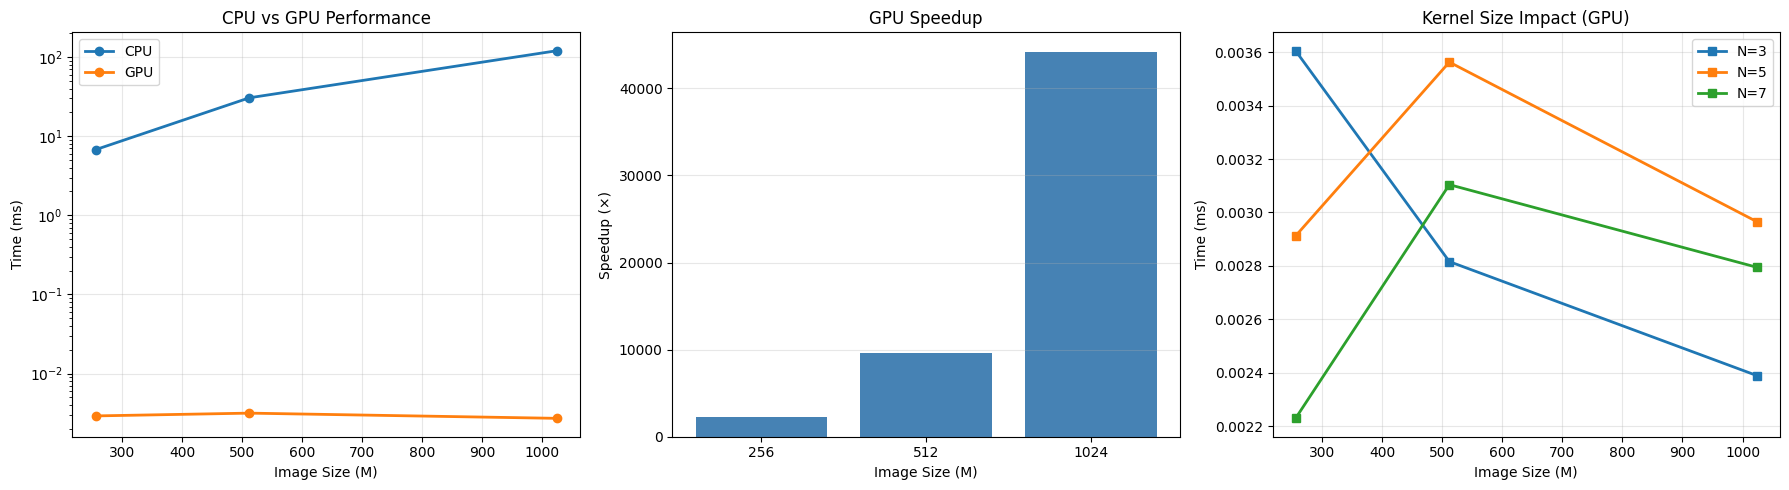

performance.png saved


In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# time comparison
for impl in ['CPU', 'GPU']:
    d = df[df['Impl']==impl].groupby('M')['Time_ms'].mean()
    axes[0].plot(d.index, d.values, marker='o', label=impl, linewidth=2)
axes[0].set_xlabel('Image Size (M)'); axes[0].set_ylabel('Time (ms)')
axes[0].set_title('CPU vs GPU Performance'); axes[0].legend(); axes[0].grid(alpha=0.3)
axes[0].set_yscale('log')

# speedup
cpu = df[df['Impl']=='CPU'].groupby('M')['Time_ms'].mean()
gpu = df[df['Impl']=='GPU'].groupby('M')['Time_ms'].mean()
speedup = cpu / gpu
axes[1].bar(range(len(speedup)), speedup.values, color='steelblue')
axes[1].set_xlabel('Image Size (M)'); axes[1].set_ylabel('Speedup (×)')
axes[1].set_title('GPU Speedup'); axes[1].set_xticks(range(len(speedup)))
axes[1].set_xticklabels(speedup.index); axes[1].grid(alpha=0.3, axis='y')

# kernel size impact
for N in [3,5,7]:
    d = df[(df['Impl']=='GPU') & (df['N']==N)]
    axes[2].plot(d['M'], d['Time_ms'], marker='s', label=f'N={N}', linewidth=2)
axes[2].set_xlabel('Image Size (M)'); axes[2].set_ylabel('Time (ms)')
axes[2].set_title('Kernel Size Impact (GPU)'); axes[2].legend(); axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('performance.png', dpi=200)
plt.show()
print("performance.png saved")

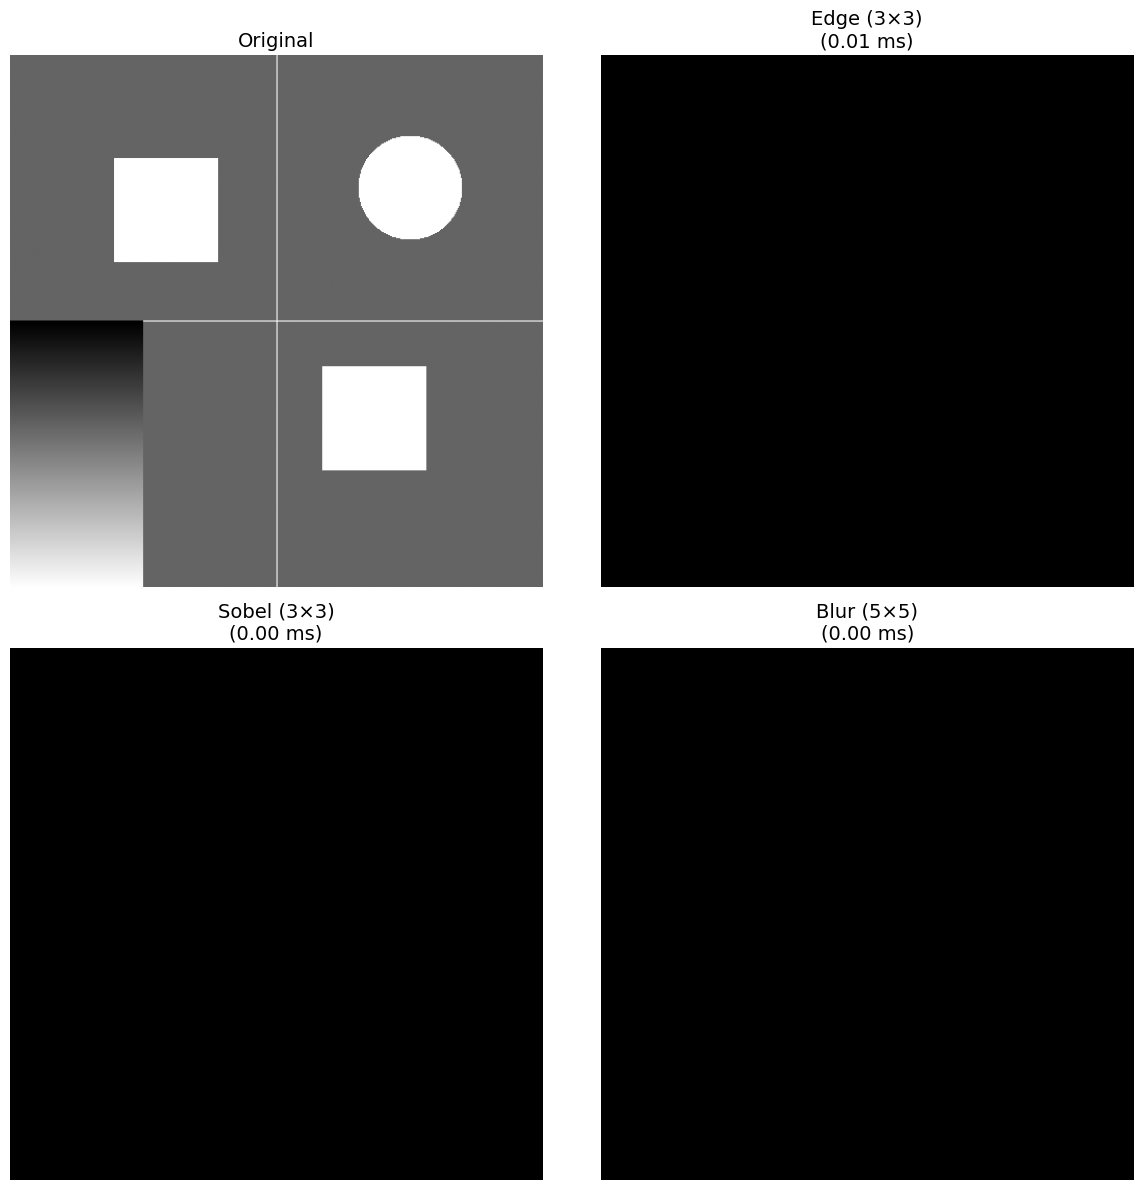

effects.png saved


In [27]:
M = 512

img = np.ones((M,M), dtype=np.uint32) * 100
img[100:200, 100:200] = 255
img[300:400, 300:400] = 255

center_x, center_y = M//4, 3*M//4
for i in range(M):
    for j in range(M):
        if (i - center_x)**2 + (j - center_y)**2 < 50**2:
            img[i, j] = 255

img[M//2, :] = 255
img[:, M//2] = 255

for i in range(M//2, M):
    img[i, 0:M//4] = int(255 * (i - M//2) / (M//2))

filters = {
    'Edge (3×3)': np.array([-1,-1,-1,-1,8,-1,-1,-1,-1], dtype=np.float32),
    'Sobel (3×3)': np.array([-1,0,1,-2,0,2,-1,0,1], dtype=np.float32),
    'Blur (5×5)': np.array([1,4,6,4,1,4,16,24,16,4,6,24,36,24,6,4,16,24,16,4,1,4,6,4,1], dtype=np.float32)/256.0
}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0,0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0,0].set_title('Original', fontsize=14)
axes[0,0].axis('off')

for idx, (name, k) in enumerate(filters.items()):
    N = int(np.sqrt(len(k)))
    out = np.zeros((M,M), dtype=np.uint32)
    t = lib.gpu_convolution(img.ravel(), k, out.ravel(), M, N)
    r,c = (idx+1)//2, (idx+1)%2
    axes[r,c].imshow(out, cmap='gray', vmin=0, vmax=255)
    axes[r,c].set_title(f'{name}\n({t:.2f} ms)', fontsize=14)
    axes[r,c].axis('off')

plt.tight_layout()
plt.savefig('effects.png', dpi=200)
plt.show()
print("effects.png saved")